## Predicting Teacher Attrition Rates for Public Schools
**This notebook explores predicting teacher attrition rates for public schools in North Carolina.** 
* Public school racial compositions are also considered when making predictions in this notebook.
* The North Carolina Educational Attainment Data Repository for Machine Learning is located on Github at: https://github.com/wtubin/TeacherRetentionofNC

**For documentation on various Generalized Linear Models in Sklearn see:**
* http://scikit-learn.org/stable/modules/linear_model.html
* https://stackoverflow.com/questions/33845539/modelling-probabilities-in-a-regularized-logistic-regression-model-in-python

In [1]:
!pip install xgboost
!pip install 
#!pip install pyshp

ERROR: You must give at least one requirement to install (see "pip help install")


In [2]:
#import required Libraries
from __future__ import division
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import StandardScaler

from sklearn import metrics as mt
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV    
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_validate

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from yellowbrick.features import JointPlotVisualizer
from scipy.stats import pearsonr
from sklearn.metrics import explained_variance_score
import xgboost


import warnings
warnings.simplefilter('ignore')

%matplotlib inline


In [3]:

ML2017 = '../2017/Machine Learning Datasets/PublicSchools2017_ML.csv'
# ML2016 = '../2016/Machine Learning Datasets/PublicSchools2016_ML.csv'
# ML2015 =  '../2015/Machine Learning Datasets/PublicSchools2015_ML.csv'
# ML2014 =  '../2014/Machine Learning Datasets/PublicSchools2014_ML.csv'

schData2017=pd.read_csv(ML2017, low_memory=False)
print('*********************************2017 ML Data*************************************')
schData2017.info()
# schData2016=pd.read_csv(ML2016, low_memory=False)
# print('*********************************2016 ML Data*************************************')
# schData2016.info()

# schData2015=pd.read_csv(ML2015, low_memory=False)
# print('*********************************2015 ML Data*************************************')
# schData2015.info()

# schData2014=pd.read_csv(ML2014, low_memory=False)
# print('*********************************2014 ML Data*************************************')
# schData2014.info()

*********************************2017 ML Data*************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2468 entries, 0 to 2467
Columns: 396 entries, student_num to unit_code
dtypes: float64(352), int64(44)
memory usage: 7.5 MB


## Fix Year

In [4]:
# schData2014["Year"]=2014
# schData2015["Year"]=2015
# schData2016["Year"]=2016
schData2017["Year"]=2017

In [5]:
# Combine the data sets
# schData = pd.concat([schData2017,schData2016,schData2015,schData2014], axis=0, ignore_index=True, sort = True)
schData = schData2017

## Remove missing data after merge

In [6]:
#Missing Data Threshold (Per Column)
missingThreshold = 0.60

#Unique Value Threshold (Per Column)
#Delete Columns >  uniqueThreshold unique values prior to one-hot encoding. 
#(each unique value becomes a new column during one-hot encoding)
uniqueThreshold = 25


#Eliminate continuous columns with more than missingThreshold percentage of missing values
schoolDataRecordCt = schData.shape[0]
missingValueLimit = schoolDataRecordCt * missingThreshold
NullValueCounts = schData.isnull().sum()
NullValueCols = NullValueCounts[NullValueCounts >= missingValueLimit].index
schData = schData.drop(NullValueCols, axis=1)

#Review dataset contents after empty field drops
print('*********After: Removing columns with >= missingThreshold % of missing values******')
schData.info(verbose=False)
print ('\r\nColumns Deleted: ', len(NullValueCols))


*********After: Removing columns with >= missingThreshold % of missing values******
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2468 entries, 0 to 2467
Columns: 396 entries, student_num to unit_code
dtypes: float64(351), int64(45)
memory usage: 7.5 MB

Columns Deleted:  0


In [7]:
#Replace all remaining NaN with 0
schData = schData.fillna(0)

#Check for Missing values after final imputation 
missing_values = schData.isnull().sum().reset_index()
missing_values.columns = ['Variable Name', 'Number Missing Values']
missing_values = missing_values[missing_values['Number Missing Values'] > 0] 
missing_values

,Variable Name,Number Missing Values


In [8]:
schData['_1yr_tchr_trnovr_pct'].describe()
# 'Number of farm returns All',
# 'Number of farm returns 100KLT200K'
# 'Number of farm returns LT25K',
# 'Number of farm returns 25KLT50K',
# 'Number of farm returns 50KLT75K',
# 'Number of farm returns 75KLT100K',
# 'Number of farm returns GE200K'

count    2468.000000
mean        0.135515
std         0.085821
min         0.000000
25%         0.077000
50%         0.125000
75%         0.182000
max         0.667000
Name: _1yr_tchr_trnovr_pct, dtype: float64

### we are not remove the 0 1 year percentage for now.

In [9]:
zeroAttrition = schData[schData['_1yr_tchr_trnovr_pct']==0.0].index
schData = schData.drop(zeroAttrition,axis=0)
print('*********After: Removing rows with first year turn over percentage =0.00******')
schData.info(verbose=False)
print ('\r\nRows Deleted: ', len(zeroAttrition))

*********After: Removing rows with first year turn over percentage =0.00******
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 1 to 2467
Columns: 396 entries, student_num to unit_code
dtypes: float64(351), int64(45)
memory usage: 7.0 MB

Rows Deleted:  143


In [10]:
 schData[schData['_1yr_tchr_trnovr_pct']==0.0]

,student_num,lea_avg_student_num,st_avg_student_num,00_Size,02_Size,03_Size,04_Size,05_Size,Math I_Size,lea_total_expense_num,...,Math SPG Grade_C,Math SPG Grade_D,Math SPG Grade_F,EVAAS Growth Status_Met,EVAAS Growth Status_NotMet,State Gap Compared_Y,Byod_Yes,_1_to_1_access_Yes,SRC_devices_sent_home_Yes,unit_code


## Visulization

### Heat map

#### 1 Year Teacher Turnover

<img src="North Carolina 2017 One Year Teacher Attrition Rate by zip code.png"></img>

#### Crime Index Rate

<img src="North Carolina 2017 Crame Index Rate by zip code.png"></img>

### Histogram

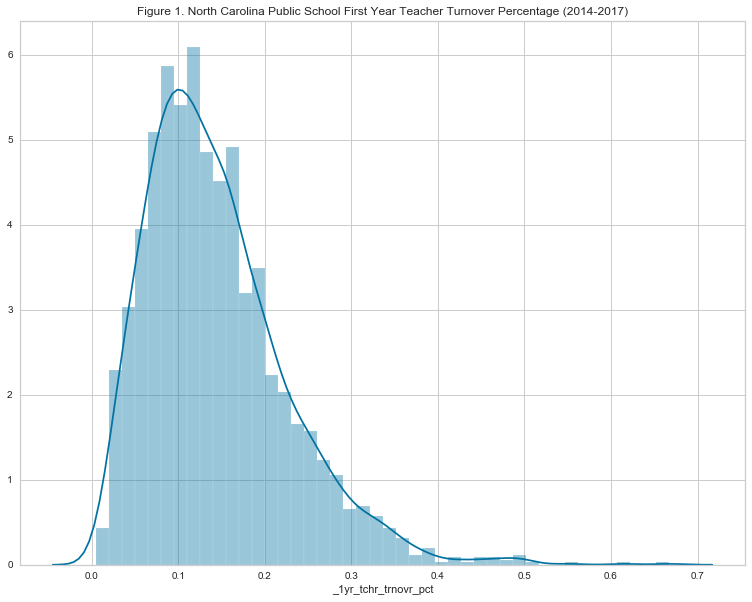

In [11]:
plt.figure(figsize=(13,10))
_1yr_tchr_trnovr_pct = schData["_1yr_tchr_trnovr_pct"]
ax = sns.distplot(_1yr_tchr_trnovr_pct);
plt.title("Figure 1. North Carolina Public School First Year Teacher Turnover Percentage (2014-2017)")
plt.show()

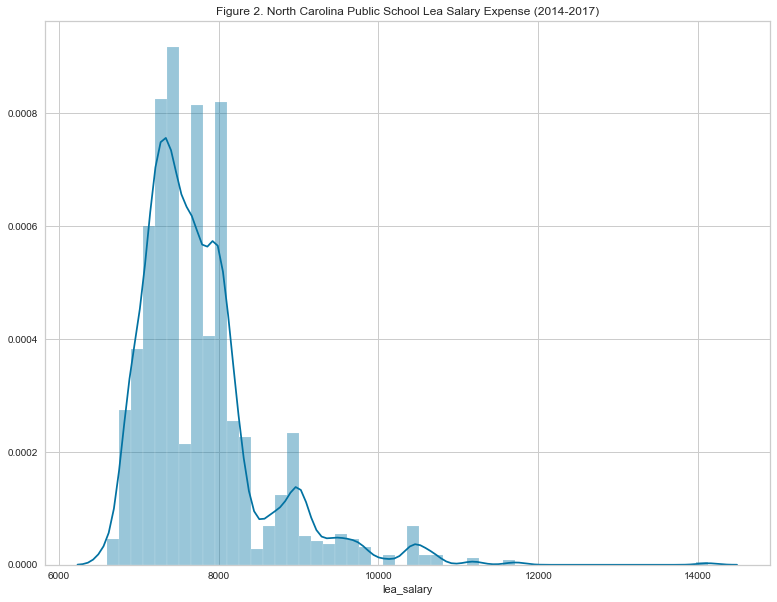

In [12]:
schData['lea_salary'] = schData['lea_total_expense_num']*schData['lea_salary_expense_pct']

plt.figure(figsize=(13,10))
lea_salary_expense_pct=schData.lea_salary_expense_pct
ax = sns.distplot(schData['lea_salary']);
plt.title("Figure 2. North Carolina Public School Lea Salary Expense (2014-2017)")
plt.show()

In [13]:
# responseible variabl distribution
schData['_1yr_tchr_trnovr_pct'].describe()

count    2325.000000
mean        0.143850
std         0.081357
min         0.005000
25%         0.086000
50%         0.129000
75%         0.186000
max         0.667000
Name: _1yr_tchr_trnovr_pct, dtype: float64

## we may want to check the outliers

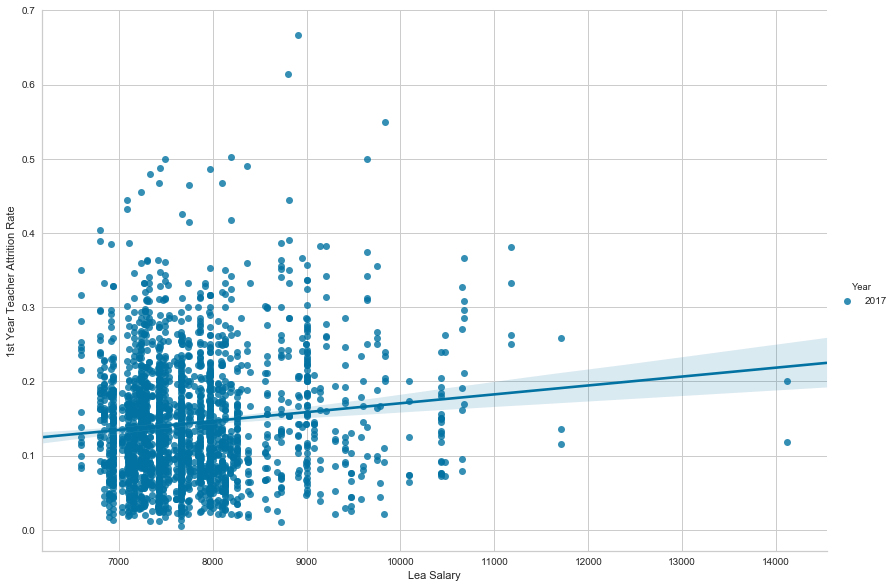

In [14]:
# #sns.set_style("darkgrid")
data = schData
sns.lmplot(x="lea_salary", y="_1yr_tchr_trnovr_pct", hue = "Year",  data=data,height=8.27, aspect=11.7/8.27)
sns.despine()

#plt.title("Figure 3. North Carolina Public School One Year Teacher Attrition Rate vs. LEA Salary Expenditure (2014-2017)")
plt.ylabel('1st Year Teacher Attrition Rate')
plt.xlabel('Lea Salary')
#plt.show()
plt.savefig('Figure1.png')

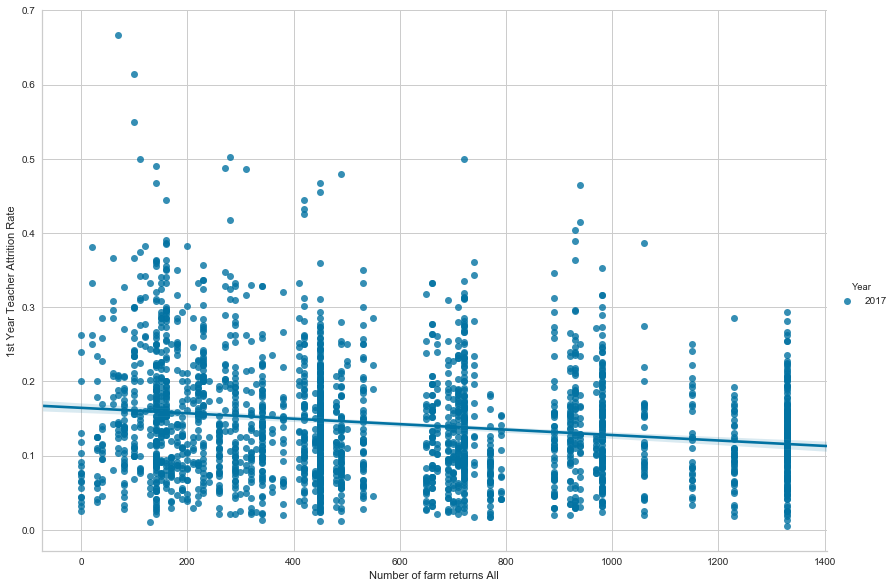

In [15]:
# #sns.set_style("darkgrid")
data = schData
sns.lmplot(x="Number of farm returns All", y="_1yr_tchr_trnovr_pct", hue="Year",  data=data,height=8.27, aspect=11.7/8.27)
sns.despine()

#plt.title("Figure 3. North Carolina Public School One Year Teacher Attrition Rate vs. LEA Salary Expenditure (2014-2017)")
plt.ylabel('1st Year Teacher Attrition Rate')
plt.xlabel('Number of farm returns All')
#plt.show()
plt.savefig('Figure1.png')


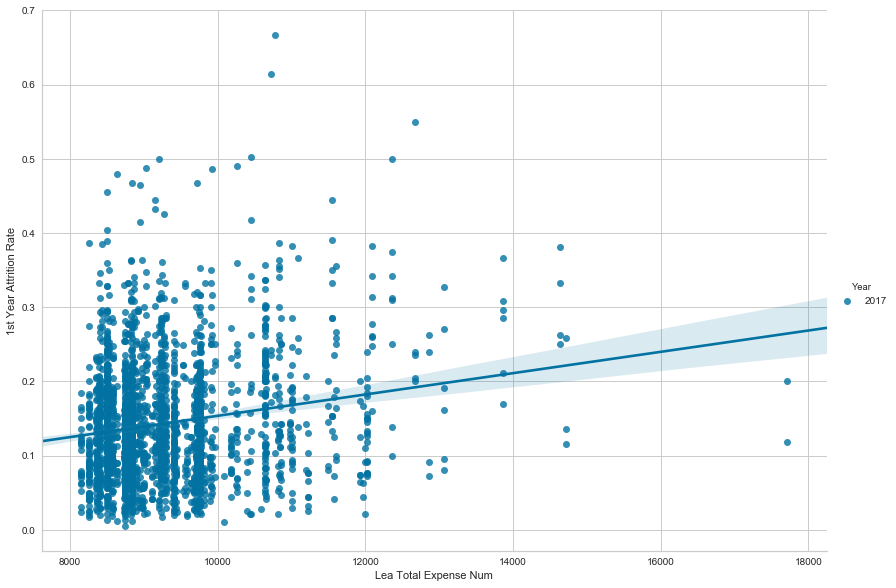

In [16]:
sns.lmplot(x="lea_total_expense_num", y="_1yr_tchr_trnovr_pct", hue="Year", data=schData,height=8.27, aspect=11.7/8.27)
sns.despine()

#plt.title("Figure 4. North Coralina Public School One Year Teacher Attrition Rate vs. LEA Total School Expenditure (2014-2017)")
plt.ylabel('1st Year Attrition Rate')
plt.xlabel('Lea Total Expense Num')
plt.savefig('Figure2.png')

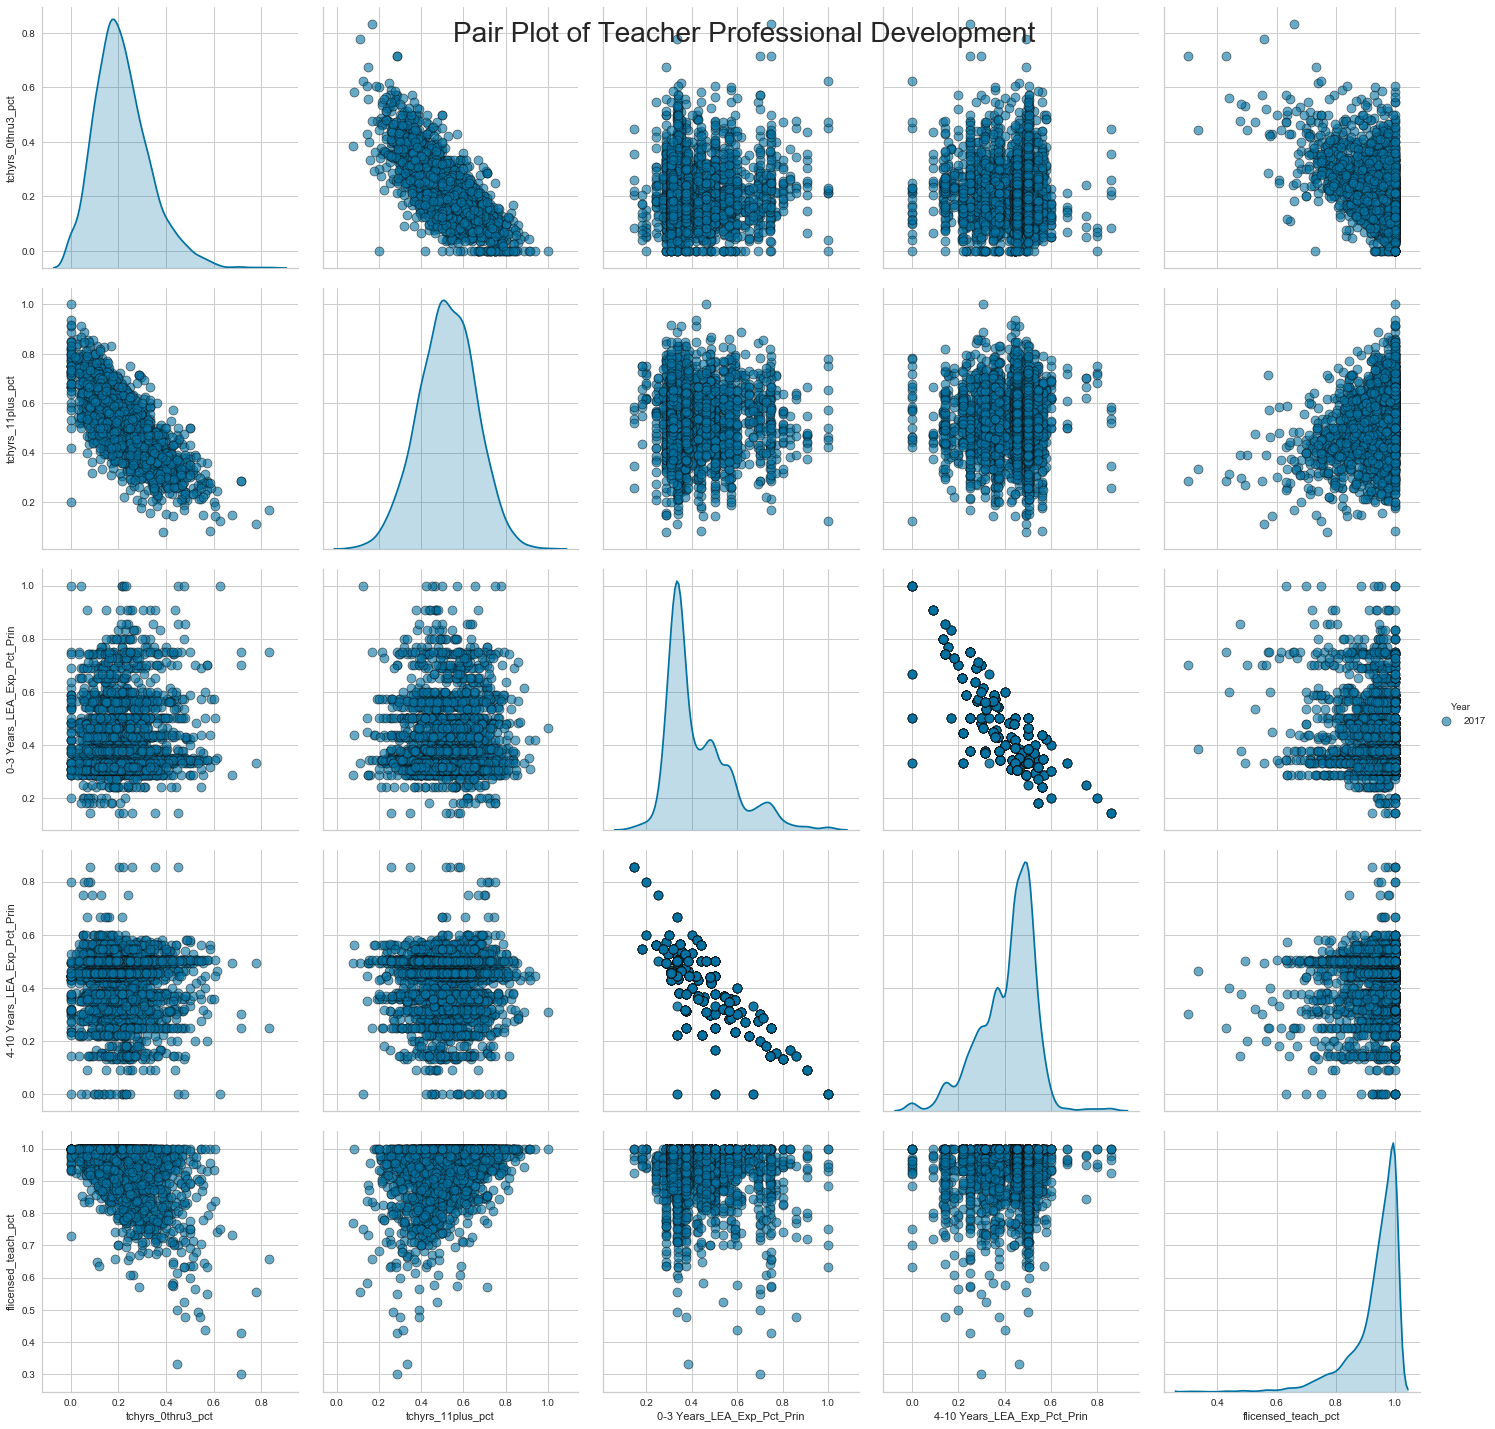

In [17]:
# pair plot
teacherProf = schData[['tchyrs_0thru3_pct','tchyrs_11plus_pct','0-3 Years_LEA_Exp_Pct_Prin','4-10 Years_LEA_Exp_Pct_Prin','flicensed_teach_pct','Year']]
sns.pairplot(teacherProf
             ,vars = ['tchyrs_0thru3_pct','tchyrs_11plus_pct','0-3 Years_LEA_Exp_Pct_Prin','4-10 Years_LEA_Exp_Pct_Prin','flicensed_teach_pct']
             , hue = 'Year', diag_kind = 'kde', plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},height = 4)
# Title 
plt.suptitle('Pair Plot of Teacher Professional Development', 
             size = 28);

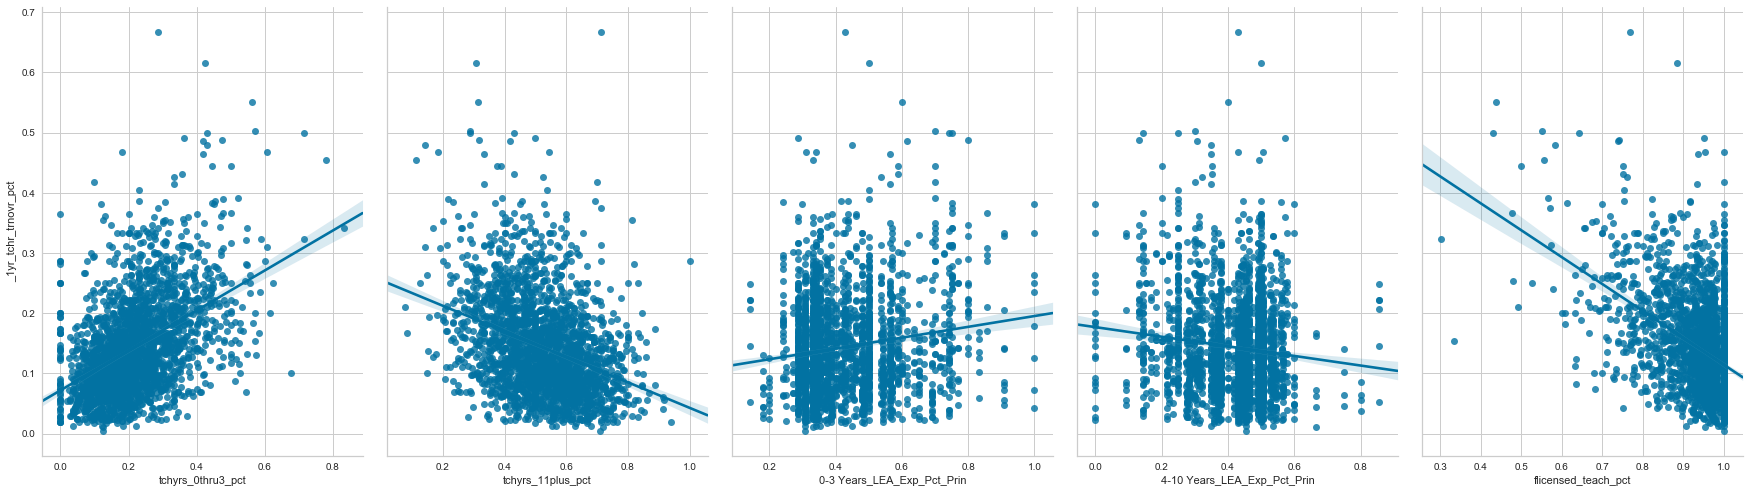

In [18]:
sns.pairplot(schData, x_vars=['tchyrs_0thru3_pct','tchyrs_11plus_pct','0-3 Years_LEA_Exp_Pct_Prin'
                              ,'4-10 Years_LEA_Exp_Pct_Prin','flicensed_teach_pct']
             , y_vars='_1yr_tchr_trnovr_pct', height=7, aspect=0.7, kind='reg')

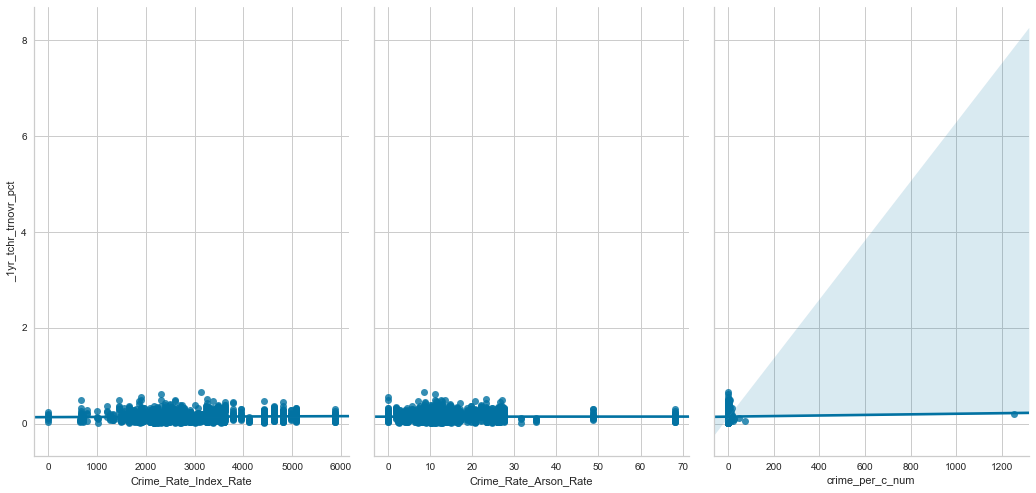

In [19]:
sns.pairplot(schData, x_vars=['Crime_Rate_Index_Rate','Crime_Rate_Arson_Rate','crime_per_c_num']
             , y_vars='_1yr_tchr_trnovr_pct', size=7, aspect=0.7, kind='reg')

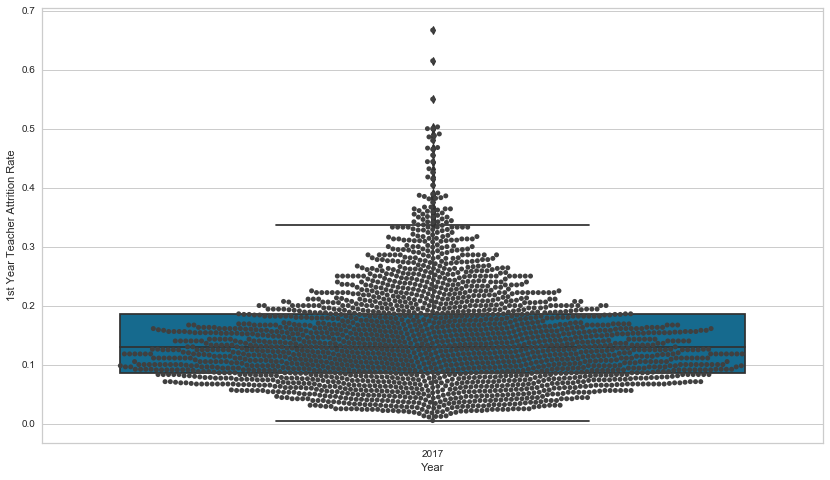

In [20]:
plt.figure(figsize=(14, 8))
ax = sns.boxplot(x="Year", y="_1yr_tchr_trnovr_pct", data=schData)
ax = sns.swarmplot(x="Year", y="_1yr_tchr_trnovr_pct", data=schData, color=".25")
plt.ylabel('1st Year Teacher Attrition Rate')
plt.xlabel('Year')
plt.savefig('Figure3.png')

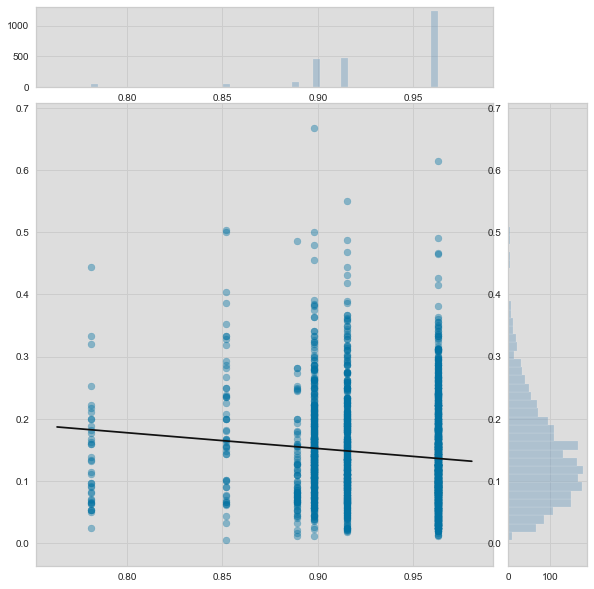

In [21]:
feature = "st_flicensed_teach_pct"
target = "_1yr_tchr_trnovr_pct"

# Get the X and y data from the DataFrame
X_feature = schData[feature]
y_feature = schData[target]

visualizer = JointPlotVisualizer(feature=feature, target=target)

visualizer.fit(X_feature, y_feature)
visualizer.poof()


In [22]:
#schData.info(verbose=True)

In [23]:
y_feature.describe()

count    2325.000000
mean        0.143850
std         0.081357
min         0.005000
25%         0.086000
50%         0.129000
75%         0.186000
max         0.667000
Name: _1yr_tchr_trnovr_pct, dtype: float64

## Feature Selection
* set max features we want to select

### Manually remove columns

* there columns is not what we are interested in, so we remove them manaually from data set

In [24]:
# manually remove the columns

ManualDropFeatures = ['st_1yr_tchr_trnovr_pct','lea_1yr_tchr_trnovr_pct'
#                       ,'PacificIslandPct','PacificIslandMalePct','PacificIslandFemalePct','HispanicPct'
#                       ,'BlackPct','AsianPct','IndianPct','WhitePct','TwoOrMorePct','TwoOrMoreMalePct','TwoOrMoreFemalePct'

#                       ,'lea_supplies_expense_pct'
#                       ,'lea_services_expense_pct','lea_salary_expense_pct'
                      ,'lea_total_expense_num'
                      #,'lea_benefits_expense_pct'
                      ,'lea_state_perpupil_num'
                      ,'lea_local_perpupil_num'
                      ,'lea_federal_perpupil_num'
                      
                      ,'st_avg_student_num'
                     ,'st_expelled_per_c_num'
                     ,'st_crime_per_c_num'
                     ,'st_avg_daily_attend_pct'
                       ,'st_tchyrs_11plus_pct'
                     ,'st_emer_prov_teach_pct'
                     ,'st_long_susp_per_c_num'
                     ,'st_flicensed_teach_pct'
                     ,'st_short_susp_per_c_num'


                     ]

schData = schData.drop(ManualDropFeatures,axis=1)
print('*********After: Removing fetures we are not interested in ******')
schData.info(verbose=False)
print ('\r\nFeatures Deleted: ', len(ManualDropFeatures))

*********After: Removing fetures we are not interested in ******
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 1 to 2467
Columns: 382 entries, student_num to lea_salary
dtypes: float64(337), int64(45)
memory usage: 6.9 MB

Features Deleted:  15


## These features have big number of the weight in feature selection, trying to remove them and see if it will be better

In [25]:
# schData = schData.drop(['Number of farm returns All','Number of farm returns 100KLT200K',
# 'Number of farm returns LT25K',
# 'Number of farm returns 25KLT50K',
# 'Number of farm returns 50KLT75K',
# 'Number of farm returns 75KLT100K',
# 'Number of farm returns GE200K'],axis=1)

In [26]:
# backup the data set
schData_bak = schData
schData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 1 to 2467
Columns: 382 entries, student_num to lea_salary
dtypes: float64(337), int64(45)
memory usage: 6.9 MB


## random shuffle the data

In [27]:
from sklearn.utils import shuffle
schData = shuffle(schData)

In [28]:
schData.head()

,student_num,lea_avg_student_num,00_Size,02_Size,03_Size,04_Size,05_Size,Math I_Size,lea_salary_expense_pct,lea_services_expense_pct,...,Math SPG Grade_D,Math SPG Grade_F,EVAAS Growth Status_Met,EVAAS Growth Status_NotMet,State Gap Compared_Y,Byod_Yes,_1_to_1_access_Yes,SRC_devices_sent_home_Yes,unit_code,lea_salary
2021,322.0,395.0,17.0,14.0,23.0,27.0,30.0,0.0,0.849,0.081,...,0,0,1,0,0,0,1,0,840312,7334.68080
327,450.0,489.0,0.0,0.0,0.0,0.0,0.0,33.0,0.854,0.061,...,0,0,1,0,0,0,0,0,180346,7149.20122
1876,118.0,459.0,10.0,13.0,13.0,20.0,0.0,0.0,0.794,0.079,...,0,0,1,0,0,0,0,0,780418,7469.07066
530,231.0,460.0,21.0,0.0,0.0,0.0,0.0,0.0,0.852,0.069,...,0,0,0,0,0,0,0,0,260412,7237.89336
2303,1484.0,1746.0,0.0,0.0,0.0,0.0,0.0,18.0,0.877,0.077,...,0,0,0,0,0,1,0,0,920562,7666.54983


In [29]:
# Get the X and y
y= schData['_1yr_tchr_trnovr_pct']
X = schData.drop(['_1yr_tchr_trnovr_pct'],axis=1)

## Transformation

In [30]:
## log transformation
#y=np.log(y)

In [31]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 2021 to 2084
Columns: 381 entries, student_num to lea_salary
dtypes: float64(336), int64(45)
memory usage: 6.8 MB


In [32]:
# Transform

saved_cols = X.columns

scaler = StandardScaler()
X = scaler.fit_transform(X)
#Save as data frames
X = pd.DataFrame(X)
X.columns = saved_cols


In [33]:
# Rescale data (between 0 and 1)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X =pd.DataFrame( scaler.fit_transform(X))
X.columns = saved_cols

In [34]:
X.head()

,student_num,lea_avg_student_num,00_Size,02_Size,03_Size,04_Size,05_Size,Math I_Size,lea_salary_expense_pct,lea_services_expense_pct,...,Math SPG Grade_D,Math SPG Grade_F,EVAAS Growth Status_Met,EVAAS Growth Status_NotMet,State Gap Compared_Y,Byod_Yes,_1_to_1_access_Yes,SRC_devices_sent_home_Yes,unit_code,lea_salary
0,0.106770,0.211153,0.629630,0.500000,0.575,0.613636,0.441176,0.000000,0.752137,0.302083,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.842620,0.097773
1,0.149882,0.262047,0.000000,0.000000,0.000,0.000000,0.000000,0.785714,0.794872,0.093750,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.172626,0.073116
2,0.038060,0.245804,0.370370,0.464286,0.325,0.454545,0.000000,0.000000,0.282051,0.281250,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.781816,0.115638
3,0.076120,0.246345,0.777778,0.000000,0.000,0.000000,0.000000,0.000000,0.777778,0.177083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.253909,0.084906
4,0.498148,0.942610,0.000000,0.000000,0.000,0.000000,0.000000,0.428571,0.991453,0.260417,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.924090,0.141890


In [35]:
# threthold for the feature selection
max_features =200

#schData = schData_bak

## Pearson Correlation

In [36]:
# Pearson Correlation
feature_name = X.columns.tolist()
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
        # replace NaN with 0
        cor_list = [0 if np.isnan(i) else i for i in cor_list]
        # feature name
        cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-max_features:]].columns.tolist()
        # feature selection? 0 for not select, 1 for select
        cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X, y)
print(str(len(cor_feature)), 'selected features')
print(pd.DataFrame( cor_feature))

200 selected features
                                                     0
0                                  lea_crime_per_c_num
1                              Crime_Rate_Violent_Rate
2                                    wap_per_classroom
3                    Add child tax credit Amt 25KLT50K
4                                   tchyrs_4thru10_pct
5                                        category_cd_H
6                  (TCE) prepared returns Ct 75KLT100K
7                          EOGReadingGr5_CACR_Hispanic
8                               SBE District_Northwest
9                           Deductible points Ct LT25K
10            Tuition and fees deduction Amt 75KLT100K
11                          10+ Years_LEA_Exp_Pct_Prin
12                             lea_long_susp_per_c_num
13                                   EOGGr3_CACR_Black
14                                   EOGGr5_CACR_Asian
15   Domestic production activities deduction Ct 25...
16   Partnership/S-corp net income (less lo

## Linear Reggesion RFE

In [37]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
rfe_selector = RFE(estimator=LinearRegression(), n_features_to_select=max_features, step=10, verbose=5)
rfe_selector.fit(X, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')
print(pd.DataFrame(rfe_feature))

Fitting estimator with 381 features.
Fitting estimator with 371 features.
Fitting estimator with 361 features.
Fitting estimator with 351 features.
Fitting estimator with 341 features.
Fitting estimator with 331 features.
Fitting estimator with 321 features.
Fitting estimator with 311 features.
Fitting estimator with 301 features.
Fitting estimator with 291 features.
Fitting estimator with 281 features.
Fitting estimator with 271 features.
Fitting estimator with 261 features.
Fitting estimator with 251 features.
Fitting estimator with 241 features.
Fitting estimator with 231 features.
Fitting estimator with 221 features.
Fitting estimator with 211 features.
Fitting estimator with 201 features.
200 selected features
                                                     0
0                                          student_num
1                                  lea_avg_student_num
2                                              03_Size
3                                              04_Size


## Linear Regression

In [38]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression

Linear = LinearRegression()

Linear_selector = SelectFromModel(Linear, threshold='1.25*median', max_features=max_features)
Linear_selector.fit(X, y)
Linear_support = Linear_selector.get_support()
Linear_feature = X.loc[:,Linear_support].columns.tolist()
print(str(len(Linear_feature)), 'selected features')
print(pd.DataFrame(Linear_feature))

170 selected features
                                                     0
0                                          student_num
1                                              03_Size
2                                              04_Size
3                               lea_salary_expense_pct
4                             lea_services_expense_pct
5                             lea_supplies_expense_pct
6                           lea_instruct_equip_exp_pct
7                                            SPG Score
8                                   EVAAS Growth Score
9                             EOG/EOCSubjects_CACR_All
10                                     EOGGr3_CACR_All
11                                     EOGGr4_CACR_All
12                          EOGGr3_CACR_AmericanIndian
13                      EOGMathGr4_CACR_AmericanIndian
14                   EOGReadingGr4_CACR_AmericanIndian
15                    EOGReadingGr5_GLP_AmericanIndian
16                 EOGScienceGr5&8_CACR_Ame

## Lasso

In [39]:

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

from sklearn.linear_model import Ridge

LassoCV = LassoCV(cv = 10,tol=0.1)

LassoCV_selector = SelectFromModel(LassoCV, threshold='1.25*median', max_features=max_features)
LassoCV_selector.fit(X, y)
LassoCV_support = LassoCV_selector.get_support()
LassoCV_feature = X.loc[:,LassoCV_support].columns.tolist()
print(str(len(LassoCV_feature)), 'selected features')
print(pd.DataFrame(LassoCV_feature))

200 selected features
                                                     0
0                                          student_num
1                                  lea_avg_student_num
2                                              00_Size
3                                              02_Size
4                                              03_Size
5                                              04_Size
6                                              05_Size
7                                          Math I_Size
8                               lea_salary_expense_pct
9                             lea_services_expense_pct
10                            lea_supplies_expense_pct
11                          lea_instruct_equip_exp_pct
12                                           SPG Score
13                                   Reading SPG Score
14                                  EVAAS Growth Score
15                                       Science Score
16                                     NC M

## Ridge Regression

In [40]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge

reg = Ridge()

reg_selector = SelectFromModel(reg, threshold='1.25*median', max_features=max_features)
reg_selector.fit(X, y)
reg_support = reg_selector.get_support()
reg_feature = X.loc[:,reg_support].columns.tolist()
print(str(len(reg_feature)), 'selected features')
print(pd.DataFrame(reg_feature))

163 selected features
                                                     0
0                                          student_num
1                                              03_Size
2                                              04_Size
3                               lea_salary_expense_pct
4                             lea_services_expense_pct
5                             lea_supplies_expense_pct
6                                            SPG Score
7                                    Reading SPG Score
8                                   EVAAS Growth Score
9                                        Science Score
10                            EOG/EOCSubjects_CACR_All
11                                     EOGGr3_CACR_All
12                                     EOGGr4_CACR_All
13                                EOCMathI_CACR_Female
14                      EOGMathGr4_CACR_AmericanIndian
15                    EOGReadingGr5_GLP_AmericanIndian
16                 EOGScienceGr5&8_CACR_Ame

## Elastic Net Regression

In [41]:
from sklearn.linear_model import ElasticNet

ELN = ElasticNet()

ELN_selector = SelectFromModel(ELN, threshold='1.25*median', max_features=max_features)
ELN_selector.fit(X, y)
ELN_support = ELN_selector.get_support()
ELN_feature = X.loc[:,ELN_support].columns.tolist()
print(str(len(ELN_feature)), 'selected features')
print(pd.DataFrame(ELN_feature))


200 selected features
                                       0
0                            student_num
1                    lea_avg_student_num
2                                00_Size
3                                02_Size
4                                03_Size
5                                04_Size
6                                05_Size
7                            Math I_Size
8                 lea_salary_expense_pct
9               lea_services_expense_pct
10              lea_supplies_expense_pct
11            lea_instruct_equip_exp_pct
12                             SPG Score
13                     Reading SPG Score
14                    EVAAS Growth Score
15                         Science Score
16                       NC Math 1 Score
17              EOG/EOCSubjects_CACR_All
18                       EOGGr3_CACR_All
19                       EOGGr4_CACR_All
20                       EOGGr5_CACR_All
21                  EOCMathI_CACR_Female
22                    EOCMathI_CACR

In [42]:
## Summary
pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name
                                     , 'Pearson':cor_support
                                     , 'Linear Regression':Linear_support
                                     , 'RFE':rfe_support
                                     , 'Lasso':LassoCV_support
                                     ,'Ridge':reg_support
                                     , 'Elastic Net':ELN_support
                                     
                                    })
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] ,
ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df

,Feature,Pearson,Linear Regression,RFE,Lasso,Ridge,Elastic Net,Total
1,student_num,True,True,True,True,True,True,6
2,lea_supplies_expense_pct,True,True,True,True,True,True,6
3,lea_services_expense_pct,True,True,True,True,True,True,6
4,lea_salary_expense_pct,True,True,True,True,True,True,6
5,SPG Score,True,True,True,True,True,True,6
6,MathGr3-8_pTarget_PctMet,True,True,True,True,True,True,6
7,EVAAS Growth Score,True,True,True,True,True,True,6
8,EOGReadingGr4_GLP_SWD,True,True,True,True,True,True,6
9,EOGGr5_CACR_White,True,True,True,True,True,True,6
10,EOGGr4_CACR_White,True,True,True,True,True,True,6


In [43]:
# export feature selection to csv file
feature_selection_df.to_csv('Feature_Selection_Results_2017.csv', sep=',', index=False)

In [44]:
feature_to_remove = feature_selection_df[feature_selection_df['Total']<3]['Feature']
X = X.drop(feature_to_remove, axis=1)

#feature_to_remove
print ('\r\nFeatures Deleted: ', len(feature_to_remove))


Features Deleted:  150


In [45]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2325 entries, 0 to 2324
Columns: 231 entries, student_num to lea_salary
dtypes: float64(231)
memory usage: 4.1 MB


## RFE Feature Importance

In [46]:
# %%time

# df2_vif = pd.DataFrame()
# df2_vif["VIF Factor"] = [vif(X.values, i) for i in range(X.shape[1])]
# df2_vif["ABSVIFFactor"] = abs(df2_vif["VIF Factor"])
# df2_vif["features"] = X.columns
# df2_vif["indexes"] = range(0, len(X.columns))

In [47]:
# df2_vif = df2_vif.sort_values('ABSVIFFactor', ascending=True)
# df2_vif.to_csv('VIF_Result_ML.csv', sep=',', index=False)

In [48]:

#Create Cross Validation Object with 10 folds with 80/20 train - test split
cv = ShuffleSplit(n_splits = 10, test_size=0.20, random_state=0)

In [49]:
#Use mean absolute error (MAE) to score the regression models created 
#(the scale of MAE is identical to the response variable)
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error, r2_score 
#from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error, r2_scorer 

#Function for Root mean squared error
#https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
def rmse(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

#Function for Mean Absolute Percentage Error (MAPE) - Untested
#Adapted from - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python
# revised from - https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn
# still not working
def mape(y_actual, y_predicted): 
    mask = y_actual != 0           
    return (np.fabs(y_actual - y_predicted)/y_actual)[mask].mean() * 100
# Credit: https://alex.miller.im/posts/linear-model-custom-loss-function-regularization-python/
def mean_absolute_percentage_error(y_true, y_pred, sample_weights=None):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    assert len(y_true) == len(y_pred)
    
    if np.any(y_true==0):
        print("Found zeroes in y_true. MAPE undefined. Removing from set...")
        idx = np.where(y_true==0)
        y_true = np.delete(y_true, idx)
        y_pred = np.delete(y_pred, idx)
        if type(sample_weights) != type(None):
            sample_weights = np.array(sample_weights)
            sample_weights = np.delete(sample_weights, idx)
        
    if type(sample_weights) == type(None):
        return(np.mean(np.abs((y_true - y_pred) / y_true)))
    else:
        sample_weights = np.array(sample_weights)
        assert len(sample_weights) == len(y_true)
        return(100/sum(sample_weights)*np.dot(
                sample_weights, (np.abs((y_true - y_pred) / y_true))
        ))
    
#Create scorers for rmse and mape functions
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)
mse_scorer = make_scorer(score_func=mean_squared_error, greater_is_better=False)
rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)
#mape_scorer = make_scorer(score_func=mape, greater_is_better=False)
r2_scorer = make_scorer(score_func=r2_score, greater_is_better=True) 

#Make scorer array to pass into cross_validate() function for producing mutiple scores for each cv fold.
errorScoring = {'MAE':  mae_scorer, 
                'MSE':  mse_scorer, 
                'RMSE': rmse_scorer,
                #'MAPE': mape_scorer,
                'R2': r2_scorer       
               } 

In [50]:
from sklearn.model_selection import cross_validate

def EvaluateRegressionEstimator(regEstimator, X, y, cv):
    
    scores = cross_validate(regEstimator, X, y, scoring=errorScoring, cv=cv, return_train_score=True)

    #cross val score sign-flips the outputs of MAE
    # https://github.com/scikit-learn/scikit-learn/issues/2439
    scores['test_MAE'] = scores['test_MAE'] * -1
    scores['test_MSE'] = scores['test_MSE'] * -1
    #scores['test_MAPE'] = scores['test_MAPE'] * -1
    scores['test_RMSE'] = scores['test_RMSE'] * -1

    #print mean MAE for all folds 
    maeAvg = scores['test_MAE'].mean()
    print_str = "The average MAE for all cv folds is: \t\t\t {maeAvg:.5}"
    print(print_str.format(maeAvg=maeAvg))

     #print mean MAE for all folds 
    mseAvg = scores['test_MSE'].mean()
    print_str = "The average MSE for all cv folds is: \t\t\t {mseAvg:.5}"
    print(print_str.format(mseAvg=mseAvg))
    
    #print mean test_MAPE for all folds
#     scores['test_MAPE'] = scores['test_MAPE']
#     mape_avg = scores['test_MAPE'].mean()
#     print_str = "The average MAE percentage (MAPE) for all cv folds is: \t {mape_avg:.5}"
#     print(print_str.format(mape_avg=mape_avg))

    #print mean MAE for all folds 
    RMSEavg = scores['test_RMSE'].mean()
    print_str = "The average RMSE for all cv folds is: \t\t\t {RMSEavg:.5}"
    print(print_str.format(RMSEavg=RMSEavg))
    print('*********************************************************')
    
    #print mean R-squared for all folds 
    R2avg = scores['test_R2'].mean()
    print_str = "The average R-Squared for all cv folds is: \t\t {R2avg:.5}"
    print(print_str.format(R2avg=R2avg))
    print('*********************************************************')


    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['MAE'] = scores['test_MAE']
    scoresResults['MSE'] = scores['test_MSE']
   # scoresResults['MAPE'] = scores['test_MAPE']
    scoresResults['RMSE'] = scores['test_RMSE']
    scoresResults['R2'] = scores['test_R2']
    return scoresResults


In [51]:
%%time


print("RFE CV Linear Regression 1st Pass")
rfecvEstimator = LinearRegression()

parameters = { 'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]
             }

#Create a grid search object  
#from sklearn.model_selection import GridSearchCV
rfecvGridSearch = GridSearchCV(estimator=rfecvEstimator
                   , n_jobs=8 # jobs to run in parallel
                  , verbose=0 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   )

#Perform hyperparameter search to find the best combination of parameters for our data using RFECV
rfecvGridSearch.fit(X, y)

#Use the best parameters for our RFECV Linear Regression object
rfecvLinearEst = rfecvGridSearch.best_estimator_

#Recursive Feature Elimination
rfecv = RFECV(estimator=rfecvLinearEst, step=1, cv=cv,  verbose=1)
X_BestFeatures = rfecv.fit_transform(X, y)

#Print RFECV Details
print("Ranking", rfecv.ranking_)
print("Support", rfecv.support_)
print("Number of Features:", rfecv.n_features_)

# print("Linear Regression Second Pass")
# #create a pipeline to scale all of the data and perform logistic regression during each grid search step.
# pipe = make_pipeline(StandardScaler(), LinearRegression())

# #Define a range of hyper parameters for grid search
# parameters = { 'linearregression__fit_intercept':[True,False], 'linearregression__normalize':[True,False]
#               , 'linearregression__copy_X':[True, False]
#               , 'linearregression__n_jobs':[None]
#              }

# #Perform the grid search using accuracy as a metric during cross validation.
# grid = GridSearchCV(estimator=pipe, param_grid=parameters, cv=cv)

# #Use the best features from recursive feature elimination during the grid search
# grid.fit(X, y)


RFE CV Linear Regression 1st Pass
Fitting estimator with 231 features.
Fitting estimator with 230 features.
Fitting estimator with 229 features.
Fitting estimator with 228 features.
Fitting estimator with 227 features.
Fitting estimator with 226 features.
Fitting estimator with 225 features.
Fitting estimator with 224 features.
Fitting estimator with 223 features.
Fitting estimator with 222 features.
Fitting estimator with 221 features.
Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Fitting estimator with 214 features.
Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitt

Fitting estimator with 228 features.
Fitting estimator with 227 features.
Fitting estimator with 226 features.
Fitting estimator with 225 features.
Fitting estimator with 224 features.
Fitting estimator with 223 features.
Fitting estimator with 222 features.
Fitting estimator with 221 features.
Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Fitting estimator with 214 features.
Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
F

Fitting estimator with 230 features.
Fitting estimator with 229 features.
Fitting estimator with 228 features.
Fitting estimator with 227 features.
Fitting estimator with 226 features.
Fitting estimator with 225 features.
Fitting estimator with 224 features.
Fitting estimator with 223 features.
Fitting estimator with 222 features.
Fitting estimator with 221 features.
Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Fitting estimator with 214 features.
Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
F

Fitting estimator with 228 features.
Fitting estimator with 227 features.
Fitting estimator with 226 features.
Fitting estimator with 225 features.
Fitting estimator with 224 features.
Fitting estimator with 223 features.
Fitting estimator with 222 features.
Fitting estimator with 221 features.
Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Fitting estimator with 214 features.
Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
F

Fitting estimator with 226 features.
Fitting estimator with 225 features.
Fitting estimator with 224 features.
Fitting estimator with 223 features.
Fitting estimator with 222 features.
Fitting estimator with 221 features.
Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Fitting estimator with 214 features.
Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
F

Fitting estimator with 224 features.
Fitting estimator with 223 features.
Fitting estimator with 222 features.
Fitting estimator with 221 features.
Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Fitting estimator with 214 features.
Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
Fitting estimator with 199 features.
Fitting estimator with 198 features.
F

Fitting estimator with 229 features.
Fitting estimator with 228 features.
Fitting estimator with 227 features.
Fitting estimator with 226 features.
Fitting estimator with 225 features.
Fitting estimator with 224 features.
Fitting estimator with 223 features.
Fitting estimator with 222 features.
Fitting estimator with 221 features.
Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Fitting estimator with 214 features.
Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
F

Fitting estimator with 229 features.
Fitting estimator with 228 features.
Fitting estimator with 227 features.
Fitting estimator with 226 features.
Fitting estimator with 225 features.
Fitting estimator with 224 features.
Fitting estimator with 223 features.
Fitting estimator with 222 features.
Fitting estimator with 221 features.
Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Fitting estimator with 214 features.
Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
F

Fitting estimator with 229 features.
Fitting estimator with 228 features.
Fitting estimator with 227 features.
Fitting estimator with 226 features.
Fitting estimator with 225 features.
Fitting estimator with 224 features.
Fitting estimator with 223 features.
Fitting estimator with 222 features.
Fitting estimator with 221 features.
Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Fitting estimator with 214 features.
Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
F

Fitting estimator with 230 features.
Fitting estimator with 229 features.
Fitting estimator with 228 features.
Fitting estimator with 227 features.
Fitting estimator with 226 features.
Fitting estimator with 225 features.
Fitting estimator with 224 features.
Fitting estimator with 223 features.
Fitting estimator with 222 features.
Fitting estimator with 221 features.
Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Fitting estimator with 214 features.
Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
F

Fitting estimator with 228 features.
Fitting estimator with 227 features.
Fitting estimator with 226 features.
Fitting estimator with 225 features.
Fitting estimator with 224 features.
Fitting estimator with 223 features.
Fitting estimator with 222 features.
Fitting estimator with 221 features.
Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Fitting estimator with 214 features.
Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
F

In [52]:
rfecv.score

<function sklearn.feature_selection.rfe.RFE.score(self, X, y)>

In [53]:
#Print the parameterization of the best estimator
regEstimator = rfecvGridSearch.best_estimator_

RFE_Results = EvaluateRegressionEstimator(regEstimator, X_BestFeatures, y, cv)

The average MAE for all cv folds is: 			 0.053425
The average MSE for all cv folds is: 			 0.0049833
The average RMSE for all cv folds is: 			 0.07053
*********************************************************
The average R-Squared for all cv folds is: 		 0.2597
*********************************************************
Cross Validation Fold Mean Error Scores


In [54]:
#Load the model's coefficient weights and feature names into a dataframe sorted by weights
weights = regEstimator.coef_.ravel()#[rfecv.get_support(indices=True)]
feature_names = X.columns#.values[rfecv.get_support(indices=True)]
#print(weights)

In [55]:
#Load the model's coefficient weights and feature names into a dataframe sorted by weights
#weights = grid.best_estimator_.named_steps['linearregression'].coef_.ravel()
#feature_names = X.columns#.values[rfecv.get_support(indices=True)]

linreg_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights,
                                 'absolute_weights': np.abs(weights)})
linreg_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False )

#Print out all the missing value rows
pd.set_option('display.max_rows', 1000)

#linreg_ft_imp_df = linreg_ft_imp_df[linreg_ft_imp_df.feature_names != 'SchoolYear']

model_features = len(linreg_ft_imp_df.index)
print('Total Model Features: ' + str(model_features))

#Print all of the features selected by the model 
linreg_ft_imp_df


Total Model Features: 231


,feature_names,weights,absolute_weights
7,lea_salary_expense_pct,-1.568947e+12,1.568947e+12
8,lea_services_expense_pct,-1.287341e+12,1.287341e+12
9,lea_supplies_expense_pct,-1.193472e+12,1.193472e+12
10,lea_instruct_equip_exp_pct,-5.900312e+11,5.900312e+11
150,tchyrs_11plus_pct,2.124303e+00,2.124303e+00
148,tchyrs_0thru3_pct,2.064522e+00,2.064522e+00
160,4-10 Years_LEA_Exp_Pct_Prin,-1.999162e+00,1.999162e+00
158,0-3 Years_LEA_Exp_Pct_Prin,-1.995157e+00,1.995157e+00
149,tchyrs_4thru10_pct,1.864890e+00,1.864890e+00
159,10+ Years_LEA_Exp_Pct_Prin,-1.533872e+00,1.533872e+00


Total Model Features: 50


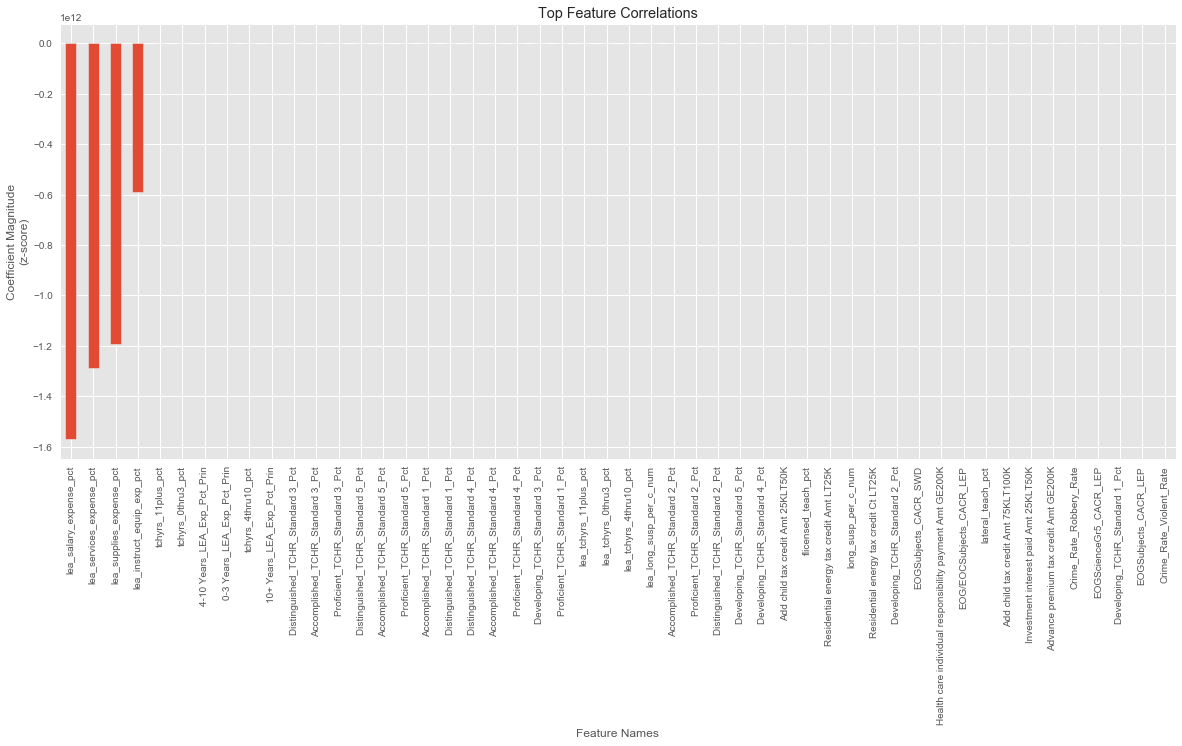

In [56]:
#Get the top 75 coefficients
wt_plt_df = linreg_ft_imp_df.head(50)

model_features = len(wt_plt_df.index)
print('Total Model Features: ' + str(model_features))

# Examine categorical variables of interest  
# import matplotlib.pyplot as plt
# %matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar', figsize=(20,8))

ax.set_title("Top Feature Correlations")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

In [57]:
# export feature selection to csv file
linreg_ft_imp_df.to_csv('RFE_Feature_Importance_Results_2017.csv', sep=',', index=False)

In [58]:
linreg_ft_imp_df50 = linreg_ft_imp_df.head(50)
linreg_ft_imp_df50.columns

Index(['feature_names', 'weights', 'absolute_weights'], dtype='object')

In [59]:
print(linreg_ft_imp_df50.feature_names)

7                                 lea_salary_expense_pct
8                               lea_services_expense_pct
9                               lea_supplies_expense_pct
10                            lea_instruct_equip_exp_pct
150                                    tchyrs_11plus_pct
148                                    tchyrs_0thru3_pct
160                          4-10 Years_LEA_Exp_Pct_Prin
158                           0-3 Years_LEA_Exp_Pct_Prin
149                                   tchyrs_4thru10_pct
159                           10+ Years_LEA_Exp_Pct_Prin
173                    Distinguished_TCHR_Standard 3_Pct
163                     Accomplished_TCHR_Standard 3_Pct
179                       Proficient_TCHR_Standard 3_Pct
175                    Distinguished_TCHR_Standard 5_Pct
165                     Accomplished_TCHR_Standard 5_Pct
181                       Proficient_TCHR_Standard 5_Pct
161                     Accomplished_TCHR_Standard 1_Pct
171                    Distingu

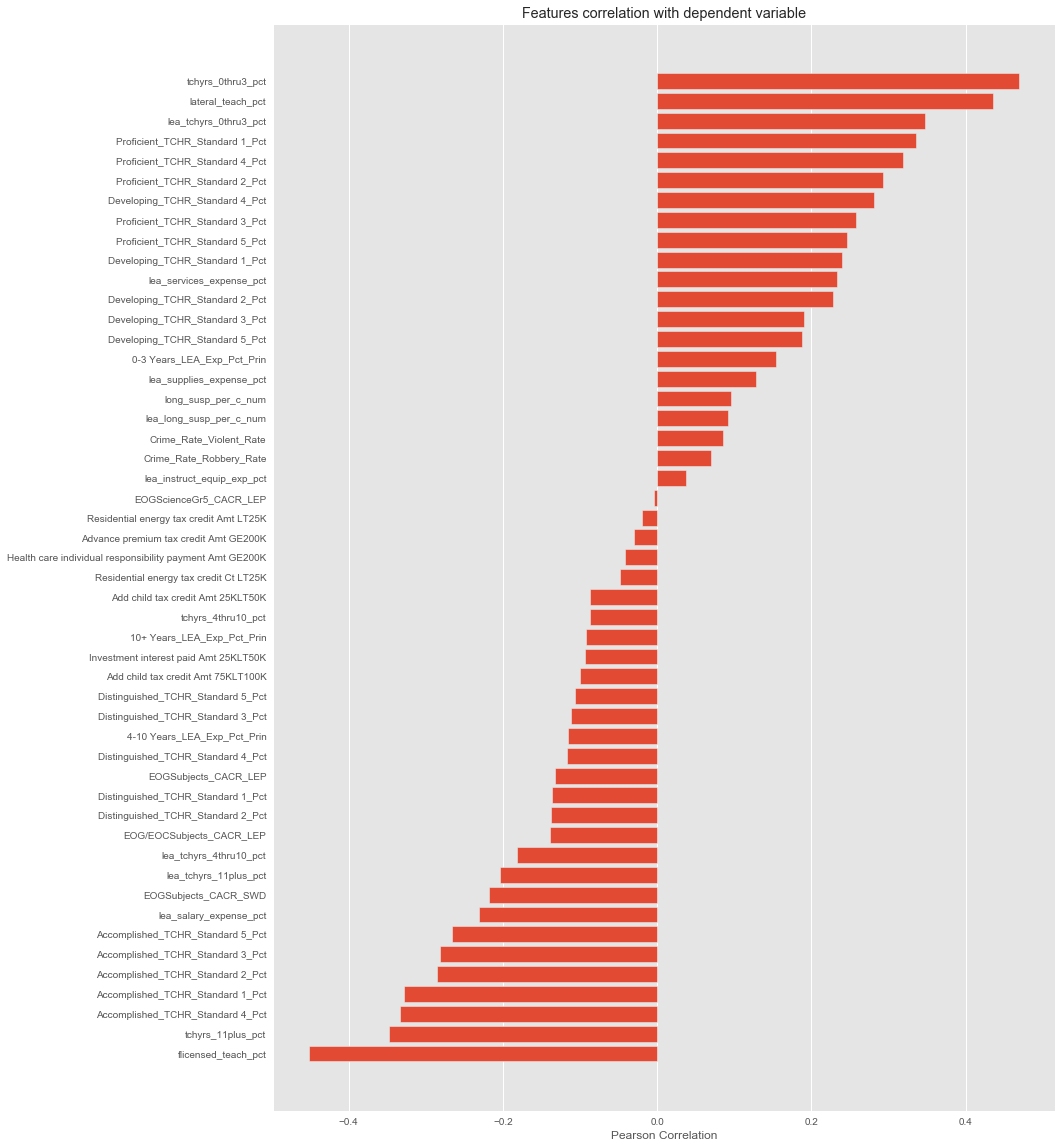

In [60]:
from yellowbrick.target import FeatureCorrelation

# Load the regression data set

feature_names = np.array(linreg_ft_imp_df50.feature_names)

X_feature = X[linreg_ft_imp_df50.feature_names]

fig = plt.figure(figsize=(14, 20))
ax = fig.add_subplot()

visualizer = FeatureCorrelation(labels=feature_names,sort=True)
visualizer.fit(X_feature, y)
visualizer.poof()

In [61]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2325 entries, 0 to 2324
Columns: 231 entries, student_num to lea_salary
dtypes: float64(231)
memory usage: 4.1 MB


## Cross Validation
**Cross validation is performed using repeated holdout using ShuffleSplit()**
* Ten folds are used
* The split is: 90% training data and 10% test data
* A random seed is set so the same random test and training splits are used each time cross validation is performed.

In [62]:
#Divide data into test and training splits
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=12)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state =12 )

In [63]:
#Shuffle and split the data into training and testing subsets
#X_train, X_valid, y_train, y_valid = train_test_split(features, labels, test_size=0.20, random_state=12)

# Success
print("Training set", X_train.shape, y_train.shape)
print("Test set", X_test.shape, y_test.shape)

Training set (1860, 231) (1860,)
Test set (465, 231) (465,)


## Custom Scorers for Evaluating Regression Models 

**All regression models created in this notebook are validated using the following metrics:**
* Mean Absolute Error (MAE)
* Root Mean Squared Error (RMSE) - https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
* Mean Absolute Percentage Error (MAPE) - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python

**For details on making scorers to return multiple mean error scores see:**
* http://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
* https://github.com/scikit-learn/scikit-learn/pull/7388
* https://github.com/drorata/multiscorer

In [64]:
# it may not make sense to use MAPE in our project based on below articles:
# http://www.catchbull.com/catchblogs/why-mape-doesnt-work


## Regression Model Evaluation
** All regression models are evaluated using the regression model evaluation function below: ** 
* The following regression evaluation function uses the cross validation object and the custom scorers in the two cells above in combination with sklearn.model_selection's cross_validate function to perform cross validation for regression estimators.
* The cross validation object above uses a random seed to ensure that all regression estimators are tested on the same randomly selected records for each cross validation fold.
* Custom scorers are created using the three chosen mean error scores and passed into cross_validate(), so all three scores are calcualted using a single call to cross_validate().
* All of this functionality is wrapped within the custom EvaluateRegressionEstimator() function below so multiple regression models may be tested using the same test / train cv data and evaluation scores producing a consistent output for each model without the need to re-write the same code over and over. 

## Baseline Regression Model

**Linear Regression is used to create a baseline model.  Since linear regression may predict response variable values outside the range of the training data's response variable, we create a linear regression estimator with graduation rate predictions clipped 0% and 100%. For details see:**
* http://scikit-learn.org/stable/developers/contributing.html#rolling-your-own-estimator 
* https://github.com/scikit-learn/scikit-learn/issues/6950
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
* https://github.com/scikit-learn-contrib/project-template/blob/master/skltemplate/template.py
* https://stackoverflow.com/questions/44234682/how-to-use-sklearn-when-target-variable-is-a-proportion

In [67]:
#Make new estimator compatible for use with GridSearchCV() and cross_validate()
# -  Cap predict function for LinearRegression between 0 and 100
# -  See: Roll your own estimator links above for details. 
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression

class CappedLinearRegression(LinearRegression):
    def predict(self, X):
        return np.clip(super(CappedLinearRegression, self).predict(X), 0, 100) 

### Linear Regression Grid Search
** Here we perform a grid search testing 40 models to find the best parameters for our Linear Regression model based on Mean Absolute Error.  See more on parameter tuning with grid search here:**
* http://scikit-learn.org/stable/modules/grid_search.html

In [68]:
#Create a Linear Regression object and perform a grid search to find the best parameters
linreg = CappedLinearRegression()
parameters = {'normalize':(True,False), 'fit_intercept':(True,False),'normalize': (True, False),}

#Create a grid search object using the  
linregGridSearch = GridSearchCV(estimator=linreg
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#linregGridSearch hyperparameter search to find the best combination of parameters for our data
linregGridSearch.fit(X_train, y_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.8s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=12, test_size=0.2, train_size=None),
             error_score='raise-deprecating',
             estimator=CappedLinearRegression(copy_X=True, fit_intercept=True,
                                              n_jobs=None, normalize=False),
             iid='warn', n_jobs=None,
             param_grid={'fit_intercept': (True, False),
                         'normalize': (True, False)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [69]:
#Print the parameterization of the best estimator
linregEstimator = linregGridSearch.best_estimator_
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
CappedLinear_Results = EvaluateRegressionEstimator(linregEstimator, X_train, y_train, cv)

The average MAE for all cv folds is: 			 0.053426
The average MSE for all cv folds is: 			 0.0049866
The average RMSE for all cv folds is: 			 0.070516
*********************************************************
The average R-Squared for all cv folds is: 		 0.28456
*********************************************************
Cross Validation Fold Mean Error Scores


In [70]:
linregEstimator = linregGridSearch.best_estimator_

linregEstimator.fit(X_train, y_train)
linregyhat = linregEstimator.predict(X_test)
print("Yhat Max: ", linregyhat.max())
print(explained_variance_score(y_test,linregyhat, multioutput='uniform_average'))

Yhat Max:  0.43856260952208714
0.39857018406406874


In [71]:
linCompare = pd.DataFrame([np.array(linregyhat),np.array(y_test)]).T
linCompare.columns=['linregyhat','y_test']

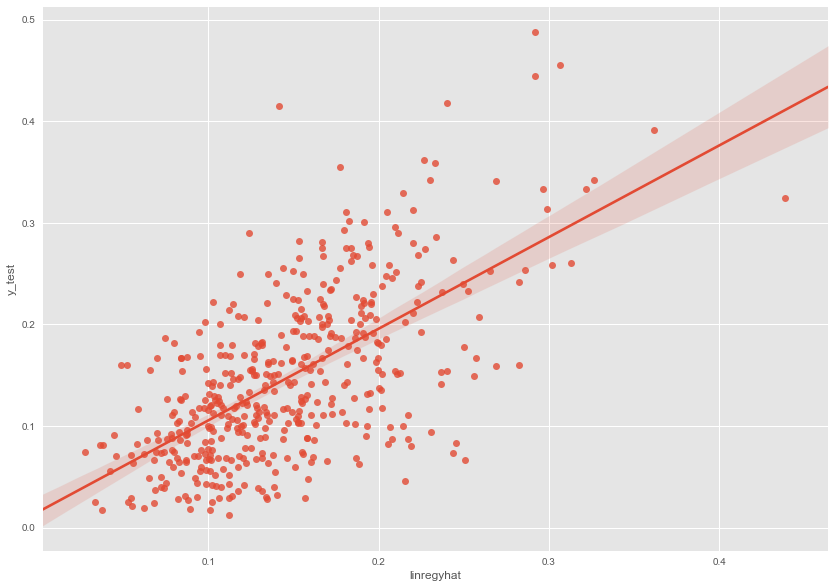

In [72]:
sns.lmplot(x="linregyhat", y="y_test",  data=linCompare,height=8.27, aspect=11.7/8.27)
sns.despine()

#plt.title("Figure 4. North Coralina Public School One Year Teacher Attrition Rate vs. LEA Total School Expenditure (2014-2017)")
plt.ylabel('y_test')
plt.xlabel('linregyhat')
plt.savefig('Figure2.png')

## Support Vector Regression
**This model uses Support Vector Machines for regression of continuous variables (SVR). Please see documentation here:"**
* http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
* http://scikit-learn.org/stable/modules/svm.html

In [73]:
#Create a Linear regression object and perform a grid search to find the best parameters
from sklearn.svm import SVR
svr = SVR()

#Set up SVR parameters to test (WARNING: Creates 320 models!!!) 
costs = [0.001, 0.1]
defGamma = 1 / X.shape[1]  #This is the default value for the gamma parameter
gammas = [defGamma, 0.1]
kernels = ['rbf','linear']
parameters = {'C': costs, 'gamma' : gammas, 'kernel': kernels}

#Create a grid search object using the parameters above
#from sklearn.model_selection import GridSearchCV
svrGridSearch = GridSearchCV(estimator=svr
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
svrGridSearch.fit(X, y)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    7.0s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=12, test_size=0.2, train_size=None),
             error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=8,
             param_grid={'C': [0.001, 0.1],
                         'gamma': [0.004329004329004329, 0.1],
                         'kernel': ['rbf', 'linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [74]:
#Display the best estimator parameters
svrGridSearch.best_estimator_

SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma=0.004329004329004329, kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [75]:
# from sklearn.svm import SVR

#Create a regression estimator with best parameters for cross validation
# regEstimator = SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
#                    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
svrEstimator = svrGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
SVR_Results=EvaluateRegressionEstimator(svrEstimator, X, y, cv)

The average MAE for all cv folds is: 			 0.055901
The average MSE for all cv folds is: 			 0.0050678
The average RMSE for all cv folds is: 			 0.071143
*********************************************************
The average R-Squared for all cv folds is: 		 0.29057
*********************************************************
Cross Validation Fold Mean Error Scores


In [76]:
#Do we predict graduation rates greater than 100%?
# regEstimator = SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
#                    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

svrEstimator.fit(X_train, y_train)
svr_yhat = svrEstimator.predict(X_test)
print("Yhat Max: ", svr_yhat.max())
print(explained_variance_score(y_test,svr_yhat, multioutput='uniform_average'))

Yhat Max:  0.42339357555655277
0.3417964295037349


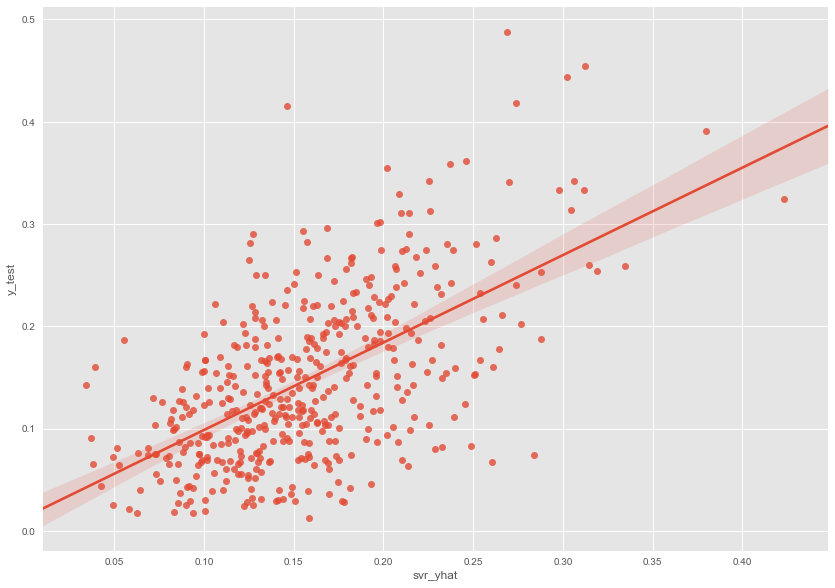

In [77]:
linCompare = pd.DataFrame([np.array(svr_yhat),np.array(y_test)]).T
linCompare.columns=['svr_yhat','y_test']

sns.lmplot(x="svr_yhat", y="y_test",  data=linCompare,height=8.27, aspect=11.7/8.27)
sns.despine()

#plt.title("Figure 4. North Coralina Public School One Year Teacher Attrition Rate vs. LEA Total School Expenditure (2014-2017)")
plt.ylabel('y_test')
plt.xlabel('svr_yhat')
plt.savefig('Figure2.png')

## Teacher Attrition Rate - Lasso Regression
**This model uses Lasso regression (L1 Norm). Please see documentation here:"**
* **Caution!** - See documentation for fit_intercept, normalize, and copy_X. Lasso can over-write your X data!
* Lasso may also perform scaling as well.  Please see docs!
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

In [78]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import Lasso

lasso = Lasso()

#Test parameters 
alpha = [0.001, 0.1, 1, 10, 20]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
lassoGridSearch = GridSearchCV(estimator=lasso
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
lassoGridSearch.fit(X, y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    1.4s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=12, test_size=0.2, train_size=None),
             error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=8,
             param_grid={'alpha': [0.001, 0.1, 1, 10, 20],
                         'selection': ['cyclic', 'random'],
                         'warm_start': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [79]:
#Display the best estimator parameters
lassoGridSearch.best_estimator_

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=True)

In [80]:
#Create a regression estimator with best parameters for cross validation
lassoEstimator =lassoGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
Lasso_Results = EvaluateRegressionEstimator(lassoEstimator, X, y, cv)

The average MAE for all cv folds is: 			 0.053466
The average MSE for all cv folds is: 			 0.0048561
The average RMSE for all cv folds is: 			 0.069624
*********************************************************
The average R-Squared for all cv folds is: 		 0.32114
*********************************************************
Cross Validation Fold Mean Error Scores


In [81]:
#Do we predict graduation rates greater than 100%?
# regEstimator = Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
#    normalize=True, positive=False, precompute=True, random_state=0,
#    selection='cyclic', tol=0.0001, warm_start=True)
lassoEstimator = lassoGridSearch.best_estimator_

lassoEstimator.fit(X_train, y_train)
Lasso_yhat = lassoEstimator.predict(X_test)
print("Yhat Max: ", Lasso_yhat.max())
print(explained_variance_score(y_test,Lasso_yhat, multioutput='uniform_average'))

Yhat Max:  0.3255378951547018
0.3462976588440648


## Ridge Regression
**This model uses Ridge regression (L2 Norm). Please see documentation here:"**
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [82]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import Ridge

ridge = Ridge(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=10000, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 5, 10, 20]
solver = [ 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
parameters = {'alpha': alpha, 'solver': solver}

#Create a grid search object using the parameters above
#from sklearn.model_selection import GridSearchCV
ridgeGridSearch = GridSearchCV(estimator=ridge
                   , n_jobs=10 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
ridgeGridSearch.fit(X, y)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.9s


ValueError: ndarray is not C-contiguous

In [ ]:
#Display the best estimator parameters
ridgeGridSearch.best_estimator_

In [ ]:
%%time
#Create a regression estimator with best parameters for cross validation
ridgeEstimator = ridgeGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
Ridge_Results = EvaluateRegressionEstimator(ridgeEstimator, X, y, cv)

In [ ]:
#Do we predict graduation rates greater than 100%?
# regEstimator = Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=10000,
#    normalize=True, random_state=0, solver='saga', tol=0.0001)
ridgeEstimator = ridgeGridSearch.best_estimator_

ridgeEstimator.fit(X_train, y_train)
ridge_yhat = ridgeEstimator.predict(X_test)
print("Yhat Max: ", ridge_yhat.max())
print(explained_variance_score(y_test,ridge_yhat))

In [83]:
linCompare = pd.DataFrame([np.array(ridge_yhat),np.array(y_test)]).T
linCompare.columns=['ridge_yhat','y_test']

sns.lmplot(x="ridge_yhat", y="y_test",  data=linCompare,height=8.27, aspect=11.7/8.27)
sns.despine()

#plt.title("Figure 4. North Coralina Public School One Year Teacher Attrition Rate vs. LEA Total School Expenditure (2014-2017)")
plt.ylabel('y_test')
plt.xlabel('ridge_yhat')
plt.savefig('Figure2.png')

NameError: name 'ridge_yhat' is not defined

## Elastic Net Regression
**This model uses Elastic Net Regression (L1 and L2 Norm mixing). Please see documentation here:"**
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

In [ ]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import ElasticNet

elasticNet = ElasticNet(fit_intercept=True, normalize=True, precompute=True, copy_X=True
          , max_iter=10000, tol=0.0001, random_state=0)
 
#Test parameters
l1_ratio = [0.001, 0.01, 0.1, 0.5, 0.75, 1]
alpha = [0.001, 0.1, 1, 10]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'l1_ratio': l1_ratio, 'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
elasticNetGridSearch = GridSearchCV(estimator=elasticNet
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
elasticNetGridSearch.fit(X, y)

In [ ]:
#Display the best estimator parameters
elasticNetGridSearch.best_estimator_

In [ ]:
#Create a regression estimator with best parameters for cross validation
elasticNetEstimator = elasticNetGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
elastic_Results = EvaluateRegressionEstimator(elasticNetEstimator, X, y, cv)

In [ ]:
#Do we predict graduation rates greater than 100%?
elasticNetEstimator =  elasticNetGridSearch.best_estimator_

elasticNetEstimator.fit(X_train, y_train)
elasticNet_yhat = elasticNetEstimator.predict(X_test)
print("Yhat Max: ", elasticNet_yhat.max())
print(explained_variance_score(y_test,elasticNet_yhat, multioutput='uniform_average'))

In [ ]:
linCompare = pd.DataFrame([np.array(ridge_yhat),np.array(y_test)]).T
linCompare.columns=['elasticNet_yhat','y_test']

sns.lmplot(x="elasticNet_yhat", y="y_test",  data=linCompare,height=8.27, aspect=11.7/8.27)
sns.despine()

#plt.title("Figure 4. North Coralina Public School One Year Teacher Attrition Rate vs. LEA Total School Expenditure (2014-2017)")
plt.ylabel('y_test')
plt.xlabel('elasticNet_yhat')
plt.savefig('Figure2.png')

## XGBoost

In [84]:
# credit: https://www.kaggle.com/mburakergenc/predictions-with-xgboost-and-linear-regression
#credit: https://www.kaggle.com/stuarthallows/using-xgboost-with-scikit-learn
# https://www.kaggle.com/jayatou/xgbregressor-with-gridsearchcv
# Various hyper-parameters to tune
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgbGridSearch = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgbGridSearch.fit(X_train,
         y_train)


Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  18 out of  18 | elapsed:   31.1s finished


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,...
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=5,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.03, 0.05, 0.07],
                         'max_depth': [5, 6, 7], 'min_child_weight': [4

In [85]:
#Display the best estimator parameters
xgbGridSearch.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=6, min_child_weight=4, missing=None, n_estimators=500,
             n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
             subsample=0.7, verbosity=1)

In [86]:
#Create a regression estimator with best parameters for cross validation
xgbEstimator = xgbGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
xgb_Results = EvaluateRegressionEstimator(xgbEstimator, X, y, cv)

The average MAE for all cv folds is: 			 0.051674
The average MSE for all cv folds is: 			 0.0045916
The average RMSE for all cv folds is: 			 0.067696
*********************************************************
The average R-Squared for all cv folds is: 		 0.35748
*********************************************************
Cross Validation Fold Mean Error Scores


In [88]:
#Do we predict graduation rates greater than 100%?
xgbEstimator =  xgbGridSearch.best_estimator_

xgbEstimator.fit(X_train, y_train)
xgb_yhat = xgbEstimator.predict(X_test)
print("Yhat Max: ", xgb_yhat.max())
print(explained_variance_score(y_test,xgb_yhat, multioutput='uniform_average'))

Yhat Max:  0.40191486
0.4077599690204544


## Residuals Plot

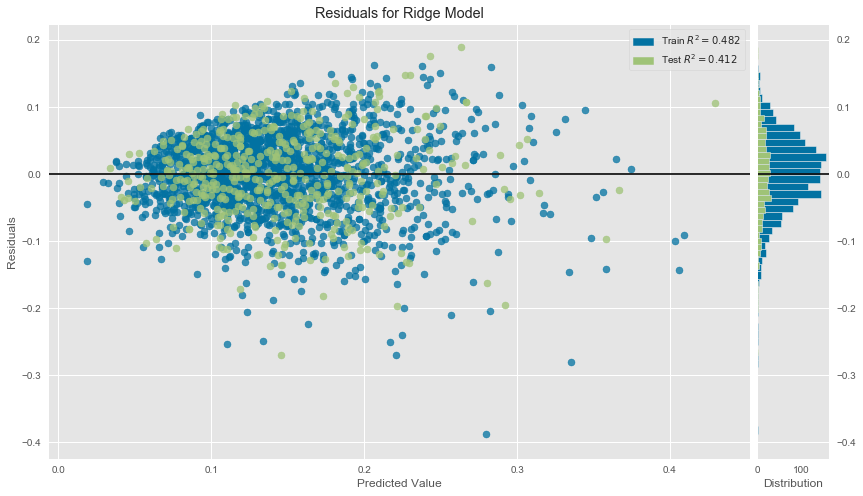

In [89]:
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot()

ridge = Ridge()
visualizer = ResidualsPlot(ridge)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

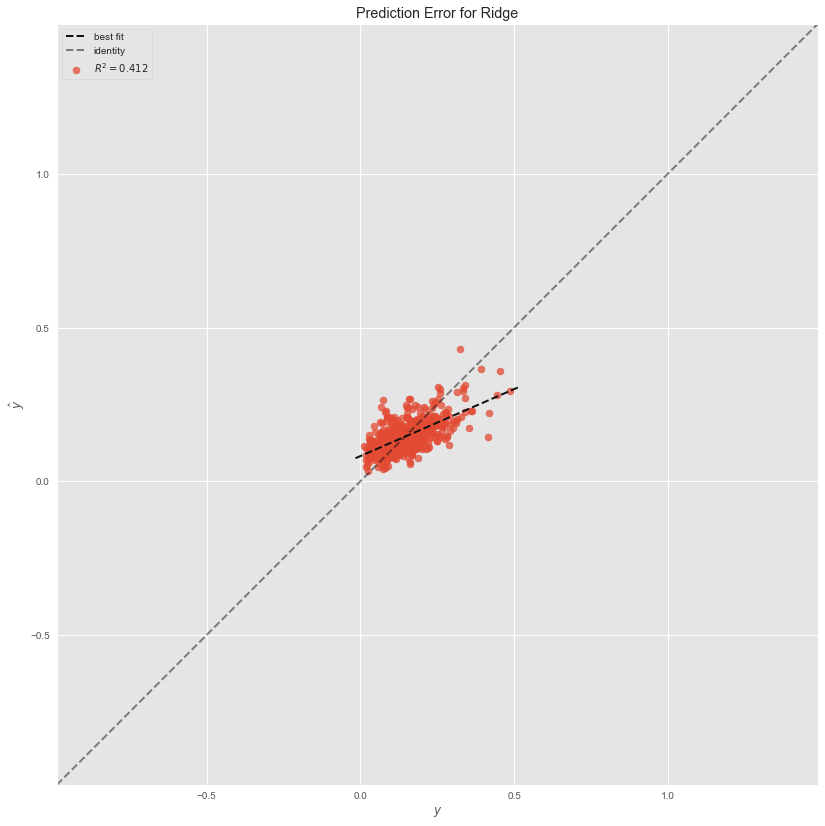

In [90]:


from yellowbrick.regressor import PredictionError

# Instantiate the linear model and visualizer

fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot()


visualizer = PredictionError(ridge)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()     

# Ridge + XGBoost


In [91]:
#Shuffle and split the data into training and testing subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=12)

# Success
print("Training set", X_train.shape, y_train.shape)
print("Validation set", X_valid.shape, y_valid.shape)

Training set (1860, 231) (1860,)
Validation set (465, 231) (465,)


In [92]:
X.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2325 entries, 0 to 2324
Data columns (total 231 columns):
student_num                                                 float64
lea_avg_student_num                                         float64
00_Size                                                     float64
02_Size                                                     float64
03_Size                                                     float64
04_Size                                                     float64
05_Size                                                     float64
lea_salary_expense_pct                                      float64
lea_services_expense_pct                                    float64
lea_supplies_expense_pct                                    float64
lea_instruct_equip_exp_pct                                  float64
SPG Score                                                   float64
Reading SPG Score                                           float64
EVAAS Gr

In [93]:
# credit: https://www.kaggle.com/priyadwivedi/kernel-ridge-regression-and-xgboost
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
def kaggle_rmse(true,pred):
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    return rmse

def r2_metric(true,pred):
    r2 = r2_score(true, pred)
    return r2

In [94]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

# Train on log of prices
#y_train = np.log(y_train)

# Train the model using the training sets
lr.fit(X_train, y_train)
pred_valid = lr.predict(X_valid)

#pred_valid_exp = np.exp(pred_valid)
#pred_linear = pred_valid

In [95]:
# Look at whats been predicted
print(y_valid.min(), y_valid.max(), y_valid.mean())
print(pred_valid.min(), pred_valid.max(), pred_valid.mean())

0.013000000000000001 0.488 0.14726666666666666
0.0277099609375 0.4386138916015625 0.146165039718792


In [96]:
print("Kaggle Score: ", kaggle_rmse(y_valid,pred_valid))
print("R2:", r2_metric(y_valid,pred_valid))

Kaggle Score:  0.06350186961329693
R2: 0.3983835560642859


In [97]:
## Ridge Regression
from sklearn import linear_model
met = linear_model.RidgeCV(alphas=[0.1,0.5, 1.0, 10.0, 15.0, 20.0, 50.0])
met.fit(X_train, y_train)
pred_valid = met.predict(X_valid)

#pred_valid_exp = np.exp(pred_valid)

# Best alpha
print("Best alpha:" ,met.alpha_)
pred_ridge = pred_valid

Best alpha: 10.0


In [98]:
print(y_valid.min(), y_valid.max(), y_valid.mean())
print(pred_valid.min(), pred_valid.max(), pred_valid.mean())

0.013000000000000001 0.488 0.14726666666666666
0.05100860913417182 0.38660503487729747 0.14597009863209978


In [99]:
print("Kaggle Score: ", kaggle_rmse(y_valid,pred_valid))
print("R2:", r2_metric(y_valid,pred_valid))

Kaggle Score:  0.0626198020116424
R2: 0.41498088738005157


In [100]:
# Lets look at important metrics
coef = pd.Series(met.coef_, index = X_train.columns)
imp_coef = pd.concat([coef.sort_values().head(20),
                     coef.sort_values().tail(20)])

In [101]:
# # Submit soln to Kaggle
# pred_test_log = met.predict(df_test_final)
# pred_test_log.shape
# pred_test_log[:5]

# pred_test_exp = np.exp(pred_test_log)
# pred_test_exp[:5]

# soln1 = pd.DataFrame({"id":test.Id, "SalePrice":pred_test_exp})
# soln1.to_csv("ridge_reg.csv", index = False)

Text(0.5, 1.0, 'Coefficients in the Ridge Model')

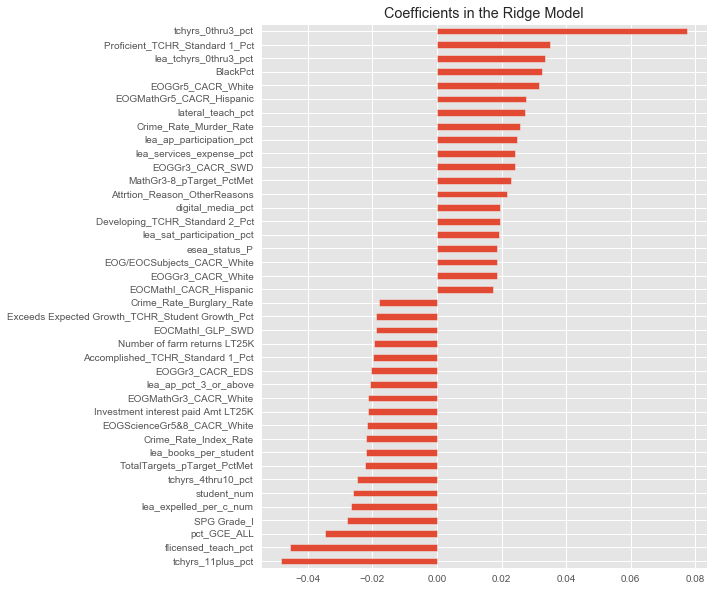

In [102]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")

In [103]:
import xgboost as xgb; print("XGBoost",xgb.__version__)
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import ShuffleSplit, cross_validate
from sklearn.model_selection import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

XGBoost 0.90


In [104]:
## Define a function to help fit chosen algorithm 
def modelfit(alg, useTrainCV=True, cv_folds=5, early_stopping_rounds=100):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, label = y_train)
        xgtest = xgb.DMatrix(X_valid)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)
    #dtrain_exp = np.exp(dtrain_predictions)
    dvalid_predictions = alg.predict(X_valid)
    #dvalid_exp = np.exp(dvalid_predictions)
            
    #Print model report:
    print("Kaggle Score - Train ", kaggle_rmse(y_train, dtrain_predictions ))
    print("Kaggle Score - Validation: ", kaggle_rmse(y_valid, dvalid_predictions ))
    print("R2 - Validation:", r2_metric(y_valid,dvalid_predictions))
    
    #print(pd.Series(alg.booster()))
                       
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

[13:18:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Kaggle Score - T

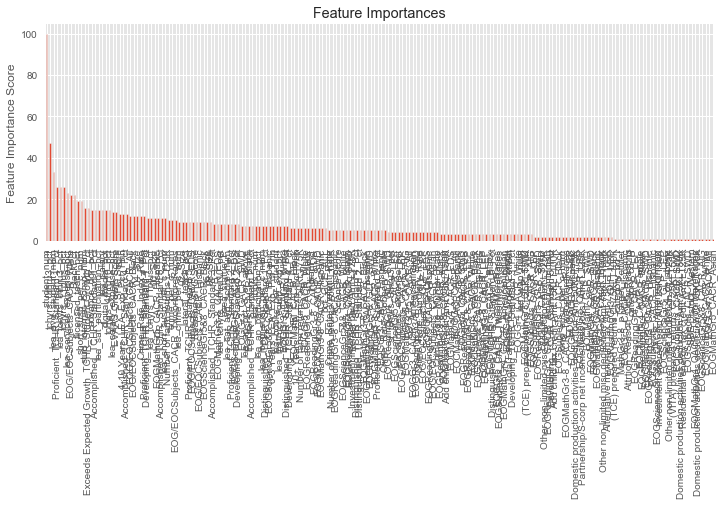

In [105]:
#C Start with a learning rate = 0.1 and look at Kaggle score and no of features 
xgb1 = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=500,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 scale_pos_weight=1,
 seed=27)

modelfit(xgb1)

[13:18:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


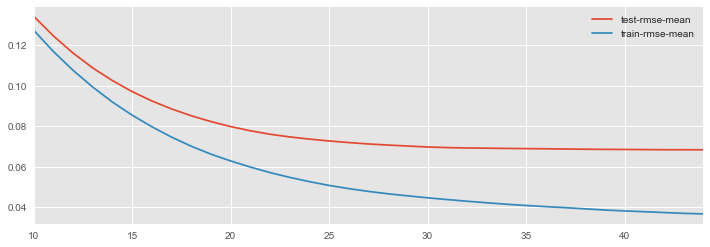

In [106]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_valid)
params = {"max_depth":5, "eta":0.1, "min_child_weight":1,
 "gamma":0,
 "subsample":0.8,
 "colsample_bytree" :0.8,
 "objective": 'reg:linear',
 "scale_pos_weight":1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)
model.loc[10:,["test-rmse-mean", "train-rmse-mean"]].plot()

[13:18:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Kaggle Score - T

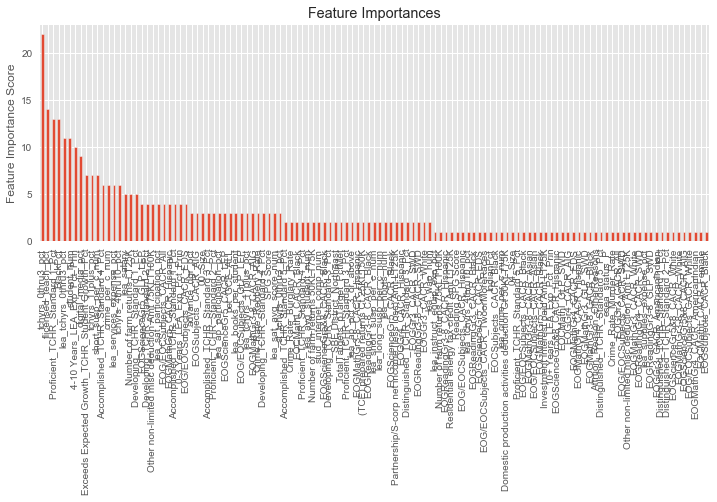

In [107]:
# Best tuned 
# max_depth =3 , min_child_weight: 3, gamma = 0, learning_rate = 0.1, 
#subsample = 0.8, colsample = 0.9, n_estimators = 400

xgb2 = xgb.XGBRegressor(
     learning_rate = 0.1,
     n_estimators=400,
     max_depth= 3,
     min_child_weight= 3,
     gamma=0,
     subsample=0.8,
     colsample_bytree= 0.9,
     objective= 'reg:linear',
     scale_pos_weight=1,
     seed=27)
modelfit(xgb2)

[13:19:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:19:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:19:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


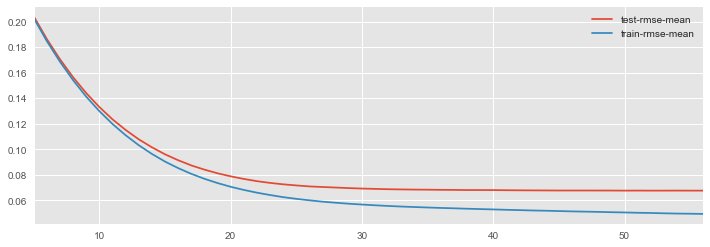

In [108]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_valid)
params = {"max_depth":3, "eta":0.1, "min_child_weight":3,
 "gamma":0,
 "subsample":0.8,
 "colsample_bytree" :0.9,
 "objective": 'reg:linear',
 "scale_pos_weight":1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)
model.loc[5:,["test-rmse-mean", "train-rmse-mean"]].plot()

[13:19:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:19:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:19:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:19:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:19:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:20:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Kaggle Score - T

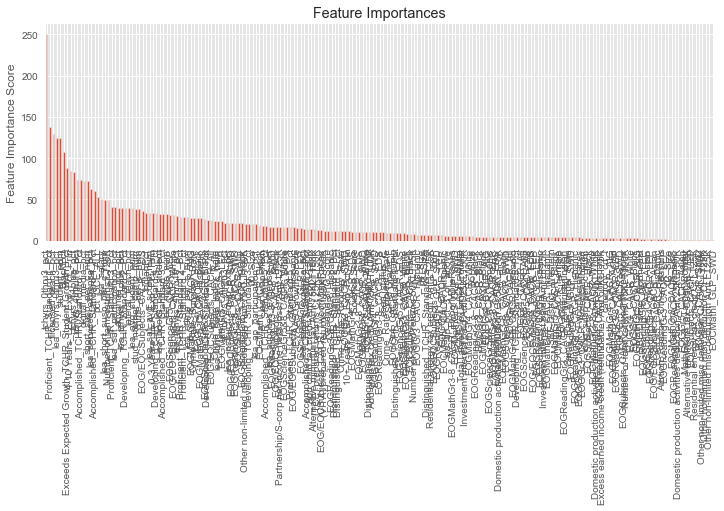

In [109]:
# Final model - reduce learning rate and add a lot of estimators
xgb4 = xgb.XGBRegressor(
     learning_rate = 0.01,
     n_estimators=5000,
     max_depth= 3,
     min_child_weight= 3,
     gamma=0,
     subsample=0.8,
     colsample_bytree= 0.9,
     objective= 'reg:linear',
     scale_pos_weight=1,
     seed=27)
modelfit(xgb4)

In [110]:
# Best regressor
model_xgb = xgb.XGBRegressor(
     learning_rate = 0.01,
     n_estimators=5000,
     max_depth= 3,
     min_child_weight= 3,
     gamma=0,
     subsample=0.8,
     colsample_bytree= 0.9,
     objective= 'reg:linear',
     scale_pos_weight=1,
     seed=27)
model_xgb.fit(X_train, y_train)
xgb_preds = model_xgb.predict(X_valid)
pred_xgb = xgb_preds
pred_xgb[:5]

[13:20:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


array([0.11519778, 0.11892527, 0.0983786 , 0.2718592 , 0.16997468],
      dtype=float32)

In [111]:
print(y_valid.min(), y_valid.max(), y_valid.mean())
print(pred_xgb.min(), pred_xgb.max(), pred_xgb.mean())

0.013000000000000001 0.488 0.14726666666666666
0.047960848 0.41953048 0.1473559


In [112]:
print("Kaggle Score: ", kaggle_rmse(y_valid,pred_xgb))
print("R2:", r2_metric(y_valid,pred_xgb))

Kaggle Score:  0.06287058312530734
R2: 0.4102857105506258


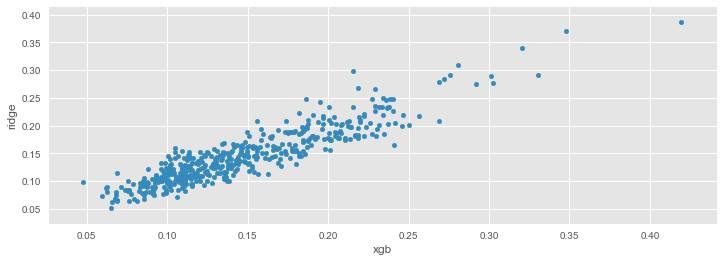

In [113]:
## Plot the two predictions
predictions = pd.DataFrame({"xgb":pred_xgb, "ridge":pred_ridge})
predictions.plot(x = "xgb", y = "ridge", kind = "scatter")

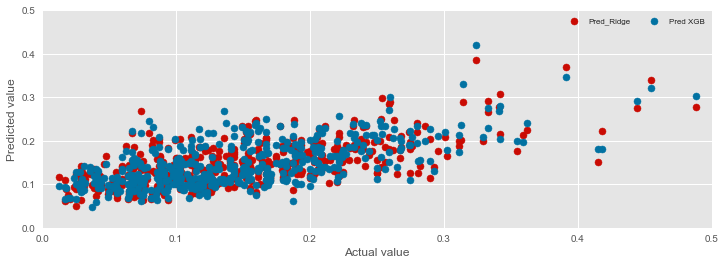

In [114]:
#Visualizing the outcome
fig, ax = plt.subplots()
ri =ax.scatter(y_valid, pred_ridge, c='r')
xgb =ax.scatter(y_valid, pred_xgb, c='b')
ax.plot([-5,-1], [-5,-1], 'r-', lw=2)
ax.set_xlabel('Actual value')
ax.set_ylabel('Predicted value')
ax.set_ylim([0, 0.5])
ax.set_xlim([0, 0.5])
plt.grid(True)
plt.legend((ri, xgb),
           ('Pred_Ridge', 'Pred XGB'),
           scatterpoints=1,
           loc='best',
           ncol=3,
           fontsize=8)
fig.savefig('Results of Regressions')   